# GeekBrains, ML in Business
# Lesson 7 Homework

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

**Импорт библиотек**

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.7 MB/s eta 0:00:00


In [34]:
! pip install category_encoders==2.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 KB 3.2 MB/s eta 0:00:00


In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 10.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import catboost as ctb
import category_encoders as ce
import shap

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score


# load JS visualization code to notebook
shap.initjs()

**Классы и функции для задания**

In [3]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Обучить и оценить модель.
    """
    model.fit(X_train, y_train, classifier__verbose=False)
    y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    
    return (model, {'f1': [f1], 'roc-auc': [roc], 'precision': [prec], 'recall': [rec]})

## Задание 1
Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php).

### Решение Задания 1

Kaggle Dataset - HR Analytics: Job Change of Data Scientists:
- https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

In [4]:
df = pd.read_csv("aug_train.csv")
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Задание 2
Сделать обзорный анализ выбранного датасета.

### Решение Задания 2

Посмотрим общие данные датасета.

In [ ]:
df.shape

(19158, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


Нужно конвертировать таргет в int, так как у нас задача классификации, а не регрессии.

In [5]:
df['target'] = df['target'].astype(int)

Смотрим баланс таргета.

In [6]:
df['target'].value_counts()

0    14381
1     4777
Name: target, dtype: int64

Есть заметный дисбаланс, но все не так плохо.

Посмотрим кардинальность категориальных (object) фичей.

In [7]:
for feat in df.select_dtypes('object').columns:
    print(f'Кардинальность {feat}: {df[feat].nunique()}')

Кардинальность city: 123
Кардинальность gender: 3
Кардинальность relevent_experience: 2
Кардинальность enrolled_university: 3
Кардинальность education_level: 5
Кардинальность major_discipline: 6
Кардинальность experience: 22
Кардинальность company_size: 8
Кардинальность company_type: 6
Кардинальность last_new_job: 6


Можно попробовать сделать one-hot encoding для признаков с кардинальностью < 10.

Посмотрим, какие категории есть у признака experience.

In [ ]:
df['experience'].value_counts()

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

Это просто кол-во лет опыта работы. Можно заменить ">20" на 21, "<1" на 0, получится вполне неплохо.

Признак city - явно просто города, в которых работают сотрудники. Чтобы закодировать этот признак, можно использовать CatBoostEncoder из библиотеки category_encoders.

Сделаем кодирование признаков в следующем задании.

## Задание 3
Сделать feature engineering.

### Решение Задания 3

Выберем числовые и категориальные признаки.

In [8]:
num_feats = df.select_dtypes('number').drop(columns='target').columns

In [9]:
cat_feats = df.select_dtypes('object').columns

Не будем брать ненужный признак enrollee_id - это просто числовой ID сотрудника.

In [10]:
num_feats = num_feats.drop('enrollee_id')

Заполняем пропуски с помощью SimpleImputer для всех категориальных признаков (на случай отсутствия будущих данных).

Заменяем все пропущенные значения категориальных признаков на самое частое значение (моду), числовых - на медиану.

In [11]:
num_imputer = Pipeline([
            ('imputer', SimpleImputer(strategy='median'))
        ])

cat_imputer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ])

imputers = ColumnTransformer([
    ('num_imputer', num_imputer, num_feats),
    ('cat_imputer', cat_imputer, cat_feats),
])

**Числовые признаки**

Просто берем их как есть.

In [12]:
class NumberTaker(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X

In [13]:
num_transformer = Pipeline([
    ('nums', NumberTaker())
])

**Энrодинг категориальных признаков**

One-hot encoding для всех признаков, кроме experience, city (кардинальность < 10).

In [14]:
cat_transformer = Pipeline([
    ('ohe', OneHotEncoder(drop='first', sparse=False))
])

Трансформер кодирования признака experience.

In [15]:
class ExperienceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):  # , y=None
        X = X.copy()
        X.loc[X[self.column_name] == '<1', self.column_name] = 0
        X.loc[X[self.column_name] == '>20', self.column_name] = 21
        X = X.astype(int)
        return X

In [16]:
experience_transformer = Pipeline([
    ('experience_transform', ExperienceTransformer('experience'))
])

Кодируем признак city с помощью CatBoostEncoder.

In [17]:
city_transformer = Pipeline([
    ('city_transform', ce.cat_boost.CatBoostEncoder())
])

Собираем все трансформации в один пайплайн.

In [18]:
transformers = ColumnTransformer([
    ('num_transformer', num_transformer, num_feats),
    ('cat_transformer', cat_transformer, cat_feats.drop(['experience', 'city'])),
    ('experience_transformer', experience_transformer, ['experience']),
    ('city_transformer', city_transformer, ['city']),
])

Собираем вместе заполнение пропусков и трансформации.

SimpleImputer возвращает данные в numpy.ndarray, поэтому нужно снова создать датафрейм, чтобы выбирать по столбцам признаков.

In [19]:
class NumpyToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

In [20]:
preprocessing = Pipeline([
    ('imputers', imputers),
    ('numpy_to_df', NumpyToDataFrame(num_feats.tolist() + cat_feats.tolist())),
    ('transforms', transformers)
])

## Задание 4
Обучить любой классификатор (какой вам нравится).

### Решение Задания 4

Делим данные на трейн и тест.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target']), df['target'], test_size=0.2, random_state=42)

In [22]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('classifier', ctb.CatBoostClassifier()), # cat_features=['experience', 'city'])),
])

In [23]:
model, model_metrics = evaluate_model(pipeline,
                                      X_train,
                                      y_train,
                                      X_test,
                                      y_test)

In [24]:
metrics = pd.DataFrame(model_metrics)

In [25]:
metrics

,f1,roc-auc,precision,recall
0,0.416044,0.623735,0.589595,0.321429


## Задание 5
Разобраться с SHAP и построить важности признаков для:
1. Всего тестового набора данных (summary_plot - дать интерпретацию),
2. Для топ 10%,
3. Для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат.

shap не поддерживает sklearn Pipeline, поэтому обработаем данные отдельно, чтобы подать их в SHAP Explainer.

In [26]:
class DataProcessor:
    def __init__(self):
        self.data_imputers = ColumnTransformer([
            ('num_imputer', num_imputer, num_feats),
            ('cat_imputer', cat_imputer, cat_feats),
        ])
        self.city_ctb_encoder = ce.cat_boost.CatBoostEncoder(return_df=True)
        self.ohe_encoder = OneHotEncoder(drop='first', sparse=False)
    
    def fit(self, X, y=None):
        # Imputers
        self.data_imputers.fit(X, y)
        # Encode city
        self.city_ctb_encoder.fit(X['city'], y)
        # One-hot encoder
        self.ohe_encoder.fit(X[cat_feats.drop(['experience', 'city'])], y)
        
        return self
    
    def transform(self, X, y=None):
        X_trans = X.drop(columns=['enrollee_id'])
        # Imputers
        X_trans = pd.DataFrame(self.data_imputers.transform(X), columns=num_feats.tolist() + cat_feats.tolist())
        # Put numeric columns back to numeric
        X_trans[['city_development_index',
                 'training_hours']] = X_trans[['city_development_index', 'training_hours']].astype(float)
        # Encode experience
        X_trans.loc[X_trans['experience'] == '<1', 'experience'] = 0
        X_trans.loc[X_trans['experience'] == '>20', 'experience'] = 21
        X_trans['experience'] = X_trans['experience'].astype(int)
        # Encode city
        X_trans['city'] = self.city_ctb_encoder.transform(X_trans['city'])
        # One-hot for low-cardinality features
        X_trans = pd.get_dummies(X_trans, drop_first=True)
#         ohe_feats = cat_feats.drop(['experience', 'city']).tolist()
#         X_trans = pd.concat([
#             X_trans.drop(columns=ohe_feats),
#             pd.DataFrame(self.ohe_encoder.transform(X_trans[ohe_feats])),
#         ], axis=1)
        
        return X_trans
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [27]:
shap_data_processor = DataProcessor().fit(X_train, y_train)
X_test_trans = shap_data_processor.transform(X_test)

In [28]:
X_test_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   city_development_index                      3832 non-null   float64
 1   training_hours                              3832 non-null   float64
 2   city                                        3832 non-null   float64
 3   experience                                  3832 non-null   int64  
 4   gender_Male                                 3832 non-null   uint8  
 5   gender_Other                                3832 non-null   uint8  
 6   relevent_experience_No relevent experience  3832 non-null   uint8  
 7   enrolled_university_Part time course        3832 non-null   uint8  
 8   enrolled_university_no_enrollment           3832 non-null   uint8  
 9   education_level_High School                 3832 non-null   uint8  
 10  education_le

### Решение Задания 5.1

Возьмем только 100 наблюдений, чтобы быстро посчитать SHAP, так как признаков 35 штук.

In [29]:
shap_data_sample = shap.utils.sample(X_test_trans, nsamples=100, random_state=0)

In [30]:
explainer = shap.KernelExplainer(pipeline.named_steps['classifier'].predict_proba, shap_data_sample)
shap_values = explainer.shap_values(shap_data_sample, silent=True)

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

Значимость признаков.

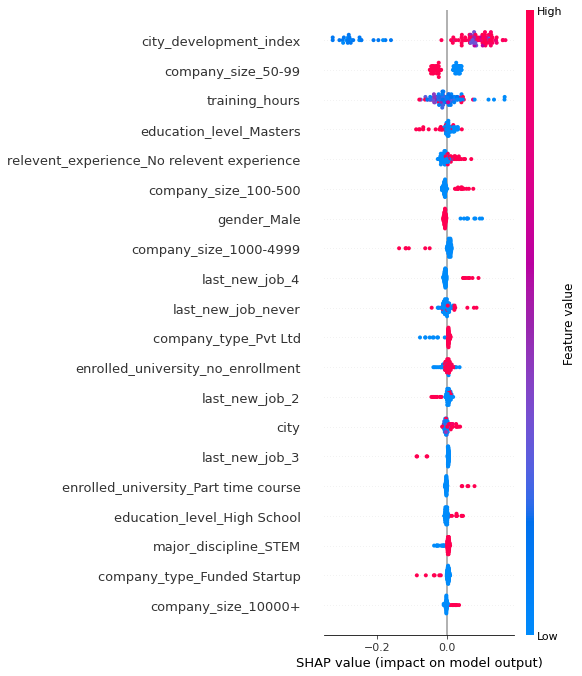

In [31]:
shap.summary_plot(shap_values[0], shap_data_sample)

Можно заметить несколько вещей:
- Чем более развит город места работы, тем вероятнее дата саентисты будут в поисках новой работы.
- Дата саентисты, не имеющие релевантного опыта работы, более склонны к поиску новой работы.
- В компаниях с 50-99 сотрудниками дата саентисты скорее предпочтут остаться на своей работе, а в более больших компаниях (100-500, 10000+ сотрудников) будут чаще искать новую работу. Что интересно, за исключением некоторых выбросах, в компаниях с 1000-4999 сотрудников дата саентисты не имеют особого предпочтения.
- Выпускники не-STEM дисциплин обучения менее склонны к поиску новой работы.
- Специалисты, работающие на текущей должности ~2 года склонны остаться на текущем месте работы, а специалисты со стажем 4 года на текущем месте работы уже больше заинтересованы в поиске новой работы.

В целом, дата саентисты и специалисты технических профессий более склонны к поиску новой работы и задач, когда они уже достаточно знакомы с текущими задачами и у них появляется желание развиваться дальше, узнавать новые вещи.

### Решение Задания 5.2

Найдем топ 10% признаков. Всего признаков 35, поэтому возьмем несколько больше - 5 признаков.

In [32]:
importance_df = pd.DataFrame({'importance': pipeline.named_steps['classifier'].get_feature_importance()},
                             index=X_test_trans.columns.tolist())
top_5_feats = importance_df.sort_values('importance', ascending=False).head(5)
top_5_feats

,importance
city_development_index,25.845570
training_hours,11.994509
last_new_job_never,10.939235
company_size_1000-4999,9.191990
last_new_job_>4,9.031172


Самые важные 5 признаков.

In [33]:
top_cols = top_5_feats.index.tolist()
top_cols

['city_development_index',
 'training_hours',
 'last_new_job_never',
 'company_size_1000-4999',
 'last_new_job_>4']

### Решение Задания 5.3

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][1], shap_data_sample.iloc[1, :])

По графику можно увидеть, что сильнее всего вероятность ухода из компании данного человека (наблюдения) уменьшается факторами:
- Развитый город места работы (индекс развития города 0.92),
- Не-мужской пол специалиста,
- Специализация в гуманитарных науках.

Что интересно, повышают вероятность ухода следующие факторы:
- Специализация не в STEM науках,
- 33 часа обучения на рабочем месте,
- Работа в стартапе.